# Multidisciplinary Design Optimization of LV4
We propose to apply design optimization methodology to the problem of design and trajectory optimization of small sounding rockets, particularly to the Portland State Aerospace Society's LV4 'space rocket'. This rocket leverages powerful liquid-fuel propulsion, a carbon-composite airframe, 6 DoF attitude control, and has a design apogee of over 100 km, above the so-called von Karman line. LV4 is currently planned for launch by 2021. 

The large amount of coupling between the design decisions in aerospace engineering design presents a singularly defining difficulty in launch vehicle development. In practice this results in a highly iterative design process that demands large investments of resources and time. This also tends to lead to a one-variable-at-a-time design thinking with concomitant requirement mismatches, developmental dead-ends and sub-optimal final design. The Portland State Aerospace Society (PSAS), being a university student group, lacks both time and fiscal support to pursue the traditional iterative approach to launch vehicle design in time for the 2021 vision goal launch date. This provides the motivation for a more targeted approach where design requirements are led by simulation and major design variables are treated all at once using convex optimization techniques. This will guid PSAS's technology development pathways, and inform requirements for future senior capstone projects sponsored by the organization. There is also a certain novelty to this work in the sense that historically there has been little published attention paid to the problem of parameter optimization in clean-sheet design of small sounding rockets.

The objective function is a summation of mass terms for the rocket including propellant, airframe and various subsystem masses. This sum represent a Gross-Lift-Off-Weight (GLOW) parameter which scales closely with design complexity and, ultimately, overall costs. Thus we wish to minimize GLOW subject to constraints including the requirement of a 100 km trajectory apogee, a Thrust-To-Weight-Ratio (TWR) greater than one, a Length-to-Diameter-Ratio (LDR) of less than 20, and a currently unspecified maximum allowable airframe dynamic pressure. Design variables include thrust, airframe diameter and length. The trajectory constraint is a simulation model using forward-Euler integration implemented in Python. There are also a large number of design constants present in the models, which include specific impulse and combustion chamber pressure, mixture ratio among others.

The optimization scheme to be used is yet to be determined, though the nature of the optimization problem is such that it is strongly non-linear with some constraints in the form of discrete simulation outputs.

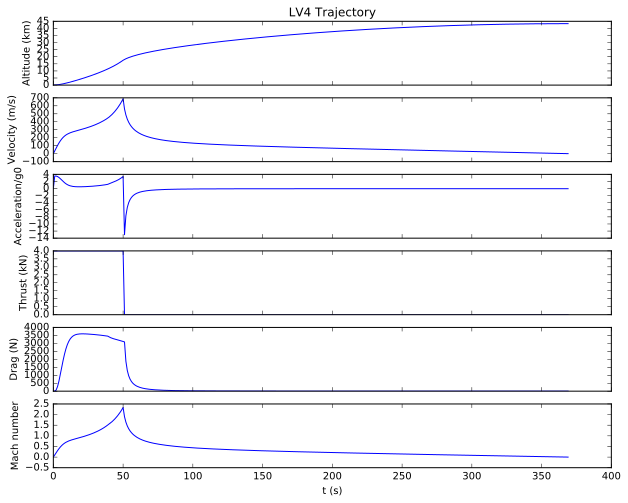

altitude at apogee = 43358.5 [m]
mission time at apogee = 369.0 [s]
TWR at lift off = 3.5


In [18]:
#A lazy start towards a simple forward Euler integration for rocket trajectories

#This whole thing is a defined function, test w/ aerobee data? Single stage LF sounding rocket analog?

from math import sqrt, pi, exp
import numpy as np

def std_at(h): #U.S. 1976 Standard Atmosphere
    if h < 11000:
        T = 15.04 - 0.00649*h
        p = 101.29*((T + 273.1)/288.08)**5.256
    
    elif 11000 <= h and h <25000:
        T = -56.46
        p = 22.65*exp(1.73 - 0.000157*h)
    
    else:
        T = -131.21 + 0.00299*h
        p = 2.488 * ((T + 273.1)/216.6)**(-11.388)
        
    rho = p/(0.2869*(T + 273.1)) #ambient air density
    p_a = p #ambient air pressure
    T_a = T + 273.1 #ambient air temperature
    return p_a, rho, T_a
    
def thrust(x, ex, p_ch, T_ch, ke, Re, mdot): #Thrust force, ignoring that isp increases w/ p_ch
    #g0 = 9.81
    #(p_a, rho, T_a) = std_at(x)
    #p_t = p_ch*(1 + (ke - 1)/2)**(-ke/(ke-1))
    #T_t = T_ch*(1/(1 + (ke - 1)/2))
    #A_t = (mdot / P_t)*m.sqrt(Re*T_t/ke)
    #A_e = ex*A_t
    #Ma_e = m.sqrt(2/(ke-1)*((p_ch/p_a)**((k-1)/k) - 1)) #is this for ideally expanded?
    #Ve = 
    
    #It would be great to find cos loss as a function of expansion ratio
    #return mdot*Ve + (p_e - p_a)*A_e #everthing else is a constant or design var, isp determined from CEA 
    F = 4000
    return F

def drag(x, v, A): #Drag force
    (p_a, rho, T_a) = std_at(x)
    C_d = .25
    """drag coefficient, placeholder scalar constant should be a function of Mach number 
    e.g. run some simulations in Star and curve fit via Cd = a*Ma**b + C_d0"""
    
    return 0.5 * rho * v**2 * C_d * A 
    
def trajectory(m_wet, m_dry, mdot, radius, ex, p_ch=350, T_ch=3500, ke=1.3, Re=100, isp=240, x_init=0):
    #physical constants
    g_0 = 9.81 #gravitational acceleration
    dt = 1 #time step
    ka = 1.4 #Ratio of specific heats, air
    Ra = 287.1 #avg. specific gas constant (dry air)

    #LV design variables
    radius = radius*0.0254 #convert in to m
    A = pi*radius**2 #airframe frontal area projected onto a circle of raduis r
    m_dry = m_dry #dry mass, call from function
    m_wet = m_wet #wet mass, call from function
    r = m_wet/(m_wet + m_dry) #mass ratio --> use to compute dV and c.f. alt potential energy
    mdot = mdot #mass flow rate
    ex = ex #expansion ratio
    p_ch = p_ch*6894.76 #chamber pressure, convert psi to Pa
    isp = isp #specific impulse


    #initial conditions
    x = [x_init]
    v = [0]
    a = [0]
    t = [0]
    rho = [std_at(x[-1])[1]]
    p_a = [std_at(x[-1])[0]]
    T_a = [std_at(x[-1])[2]]
    m_wet = [m_wet]
    m = [m_dry + m_wet[-1]]
    F = [thrust(x[-1], ex, p_ch, T_ch, ke, Re, mdot)]
    D = [0]
    Ma = [0]

    while True:
        if np.isnan(x[-1]) == True:
           return x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR
            
        p_a.append(std_at(x[-1])[0])
        rho.append(std_at(x[-1])[1])
        T_a.append(std_at(x[-1])[2])
        if m_wet[-1] > 0:
            F.append(thrust(x[-1], ex, p_ch, T_ch, ke, Re, mdot))
            
        else:
            F.append(0)
            mdot = 0
            m_wet[-1] = 0
        
        D.append(drag(x[-1], v[-1], A))
        a.append((F[-1] - D[-1] - g_0)/m[-1])
        v.append(a[-1]*dt + v[-1])
        x.append(v[-1]*dt + x[-1]), 
        Ma.append(v[-1]/sqrt(ka*Ra*T_a[-1]))
        t.append(t[-1] + dt)
        m_wet.append(m_wet[-1] - mdot*dt)
        m.append(m_dry + m_wet[-1])
        TWR = a[1]/g_0
        if v[-1] <= 0:
            x = np.array(x)
            a = np.array(a)
            F = np.array(F)
            return x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR
            
#if __name__ == "__main__":
    # test

m_wet = 90
m_dry  = 25
mdot = 4 * 0.453592* 1.0 #1 lb/s to kg/s * 4 (should result in roughly 4 kN thrust)
radius = 14
ex = 5

(x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR) = trajectory(m_wet, m_dry, mdot, radius, ex)

import matplotlib
import matplotlib.pyplot as plt
import pylab
%config InlineBackend.figure_formats=['svg']
%matplotlib inline

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True)
#plt.xlim(0, 1.8)
ax1.plot(t, x/1000)
ax1.set_ylabel("Altitude (km)")
ax1.set_title('LV4 Trajectory')
ax2.plot(t, v)
ax2.set_ylabel("Velocity (m/s)")
ax3.plot(t, a/9.81)
ax3.set_ylabel("Acceleration/g0")
ax4.plot(t, F/1000)
ax4.set_ylabel("Thrust (kN)")
ax5.plot(t, D)
ax5.set_ylabel("Drag (N)")
ax6.plot(t, Ma)
ax6.set_ylabel("Mach number")
ax6.set_xlabel("t (s)")
plt.show()

print('altitude at apogee = {0:.1f} [m]'.format(x[-1]))
print('mission time at apogee = {0:.1f} [s]'.format(t[-1]))
print('TWR at lift off = {0:.1f}'.format(a[1]/g_0))